In [1]:
from collections import Counter
from IPython.display import display
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pandas_profiling import ProfileReport
from pywaffle import Waffle
import squarify
import seaborn as sns
from wordcloud import WordCloud

pd.set_option("display.max_columns", None)
%matplotlib inline

# User define variable and Setup
import warnings
warnings.filterwarnings("ignore")

In [2]:
credit = pd.read_csv(os.path.join('tmdb_5000_credits.csv'))
movie = pd.read_csv(os.path.join('tmdb_5000_movies.csv'))

In [3]:
credit.head(2)

,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."


In [4]:
movie.head(2)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500


# 1. Data describing

The first dataset contains the following features:

- movie_id: A unique identifier for each movie.
- title: The title of the movie
- cast: The name of lead and supporting actors.
- crew: The name of Director, Editor, Composer, Writter, Sound, Camera, etc

The second dataset has the following features:

- budget: The budget in which the movie was made.
- genres: The genres of the movie such as Action, Adventure, ...
- homepage: A link to the homepage of the movie.
- id: This is infact the movie_id in the first dataset.
- keywords: The keywords or tags related to the movie.
- original_language: The language in which the movie was made
- original_title: the title of the movie before translation or adaptation. 
- overview: A brief description of the movie.
- popularity: A numeric quantity specifying the movie popularity
- production_companies: The production house of the movie.
- production_countries:The country in which it was produced.
- release_date: The date on which it was released.
- revenue: The worldwide revenue generated by the movie.
- runtime: The running time of the movie in minutes. 
- spoken_languages:  The language in which the actor was speaking.
- status: 'Released', 'Post Production', 'Rumored'
- tagline: Movie's tagline
- title: Title of the movie 
- vote_average: Average ratings the movie recieved. 
- vote_count: The count of votes recieved.

In [5]:
# merge this two dataset
credit.columns = ['id','tittle','cast','crew']
movie_df = movie.merge(credit, on='id')
del movie
del credit
del movie_df["homepage"]
del movie_df["tagline"]
del movie_df["overview"]
del movie_df["tittle"]

In [6]:
movie_df.head(1)

,budget,genres,id,keywords,original_language,original_title,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,title,vote_average,vote_count,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Avatar,7.2,11800,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."


In [169]:
# # the fastest way to get familiarize dataset and see much information
# report = ProfileReport(movie_df)
# report

In [7]:
# convert date appropriate format
movie_df["release_date"] = pd.to_datetime(movie_df['release_date'])
movie_df['release_year'] = movie_df['release_date'].dt.year
movie_df['release_month'] = movie_df['release_date'].dt.month_name()
movie_df['release_dayofweek'] = movie_df['release_date'].dt.day_name()
del movie_df["release_date"]

In [8]:
# fill some missing values by most frequent one
for col in ["runtime", "release_year", "release_month", 'release_dayofweek']:
    movie_df[col] = movie_df[col].fillna(movie_df[col].mode().iloc[0])

In [9]:
# transform all columns which had json string into json format
# several columns has id and name
# leave only name for them beacause id is not so important in this case
json_columns = {'cast', 'crew', 'genres', 'keywords', 'production_countries', 
                'production_companies', 'spoken_languages'}

for c in json_columns:
    movie_df[c] = movie_df[c].apply(json.loads)
    if c != "crew": # We need other information besides the name
        movie_df[c] = movie_df[c].apply(lambda row: [x["name"] for x in row])

In [10]:
# create profit column
movie_df["profit"] = movie_df["revenue"] - movie_df["budget"]

In [11]:
movie_df.head(2)

,budget,genres,id,keywords,original_language,original_title,popularity,production_companies,production_countries,revenue,runtime,spoken_languages,status,title,vote_average,vote_count,cast,crew,release_year,release_month,release_dayofweek,profit
0,237000000,"[Action, Adventure, Fantasy, Science Fiction]",19995,"[culture clash, future, space war, space colon...",en,Avatar,150.437577,"[Ingenious Film Partners, Twentieth Century Fo...","[United States of America, United Kingdom]",2787965087,162.0,"[English, Español]",Released,Avatar,7.2,11800,"[Sam Worthington, Zoe Saldana, Sigourney Weave...","[{'credit_id': '52fe48009251416c750aca23', 'de...",2009.0,December,Thursday,2550965087
1,300000000,"[Adventure, Fantasy, Action]",285,"[ocean, drug abuse, exotic island, east india ...",en,Pirates of the Caribbean: At World's End,139.082615,"[Walt Disney Pictures, Jerry Bruckheimer Films...",[United States of America],961000000,169.0,[English],Released,Pirates of the Caribbean: At World's End,6.9,4500,"[Johnny Depp, Orlando Bloom, Keira Knightley, ...","[{'credit_id': '52fe4232c3a36847f800b579', 'de...",2007.0,May,Saturday,661000000


# 2. Evaluation Quality of Data

In [12]:
# Check null data
movie_df.isnull().sum()

budget                  0
genres                  0
id                      0
keywords                0
original_language       0
original_title          0
popularity              0
production_companies    0
production_countries    0
revenue                 0
runtime                 0
spoken_languages        0
status                  0
title                   0
vote_average            0
vote_count              0
cast                    0
crew                    0
release_year            0
release_month           0
release_dayofweek       0
profit                  0
dtype: int64

In [13]:
# Check data types
movie_df.dtypes

budget                    int64
genres                   object
id                        int64
keywords                 object
original_language        object
original_title           object
popularity              float64
production_companies     object
production_countries     object
revenue                   int64
runtime                 float64
spoken_languages         object
status                   object
title                    object
vote_average            float64
vote_count                int64
cast                     object
crew                     object
release_year            float64
release_month            object
release_dayofweek        object
profit                    int64
dtype: object

In [14]:
movie_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4803 entries, 0 to 4802
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                4803 non-null   int64  
 1   genres                4803 non-null   object 
 2   id                    4803 non-null   int64  
 3   keywords              4803 non-null   object 
 4   original_language     4803 non-null   object 
 5   original_title        4803 non-null   object 
 6   popularity            4803 non-null   float64
 7   production_companies  4803 non-null   object 
 8   production_countries  4803 non-null   object 
 9   revenue               4803 non-null   int64  
 10  runtime               4803 non-null   float64
 11  spoken_languages      4803 non-null   object 
 12  status                4803 non-null   object 
 13  title                 4803 non-null   object 
 14  vote_average          4803 non-null   float64
 15  vote_count           

In [15]:
# Check skew of numeric columns
movie_df.skew(numeric_only=True)

budget          2.437211
id              2.072080
popularity      9.721416
revenue         4.444716
runtime         0.716616
vote_average   -1.959710
vote_count      3.824069
release_year   -2.289104
profit          5.001243
dtype: float64

In [16]:
# Statistics descriptive
CategoryStatsDF = movie_df.describe(exclude=[np.number])
NumericStatsDF = movie_df.describe(include=[np.number])
display(CategoryStatsDF)
display(NumericStatsDF)
print(movie_df.shape)

,genres,keywords,original_language,original_title,production_companies,production_countries,spoken_languages,status,title,cast,crew,release_month,release_dayofweek
count,4803,4803,4803,4803,4803,4803,4803,4803,4803,4803,4803,4803,4803
unique,1175,4222,37,4801,3697,469,530,3,4800,4761,4776,12,7
top,[Drama],[],en,Out of the Blue,[],[United States of America],[English],Released,The Host,[],[],September,Friday
freq,370,412,4505,2,351,2977,3171,4795,2,43,28,589,2054


,budget,id,popularity,revenue,runtime,vote_average,vote_count,release_year,profit
count,4.803000e+03,4803.000000,4803.000000,4.803000e+03,4803.000000,4803.000000,4803.000000,4803.000000,4.803000e+03
mean,2.904504e+07,57165.484281,21.492301,8.226064e+07,106.868832,6.092172,690.217989,2002.470123,5.321560e+07
std,4.072239e+07,88694.614033,31.816650,1.628571e+08,22.609847,1.194612,1234.585891,12.413419,1.359677e+08
min,0.000000e+00,5.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,1916.000000,-1.657101e+08
25%,7.900000e+05,9014.500000,4.668070,0.000000e+00,94.000000,5.600000,54.000000,1999.000000,-7.995375e+05
50%,1.500000e+07,14629.000000,12.921594,1.917000e+07,103.000000,6.200000,235.000000,2005.000000,2.511317e+06
75%,4.000000e+07,58610.500000,28.313505,9.291719e+07,117.500000,6.800000,737.000000,2011.000000,5.531286e+07
max,3.800000e+08,459488.000000,875.581305,2.787965e+09,338.000000,10.000000,13752.000000,2017.000000,2.550965e+09


(4803, 22)


# 3. Data visualization

- budget, revenue, profit

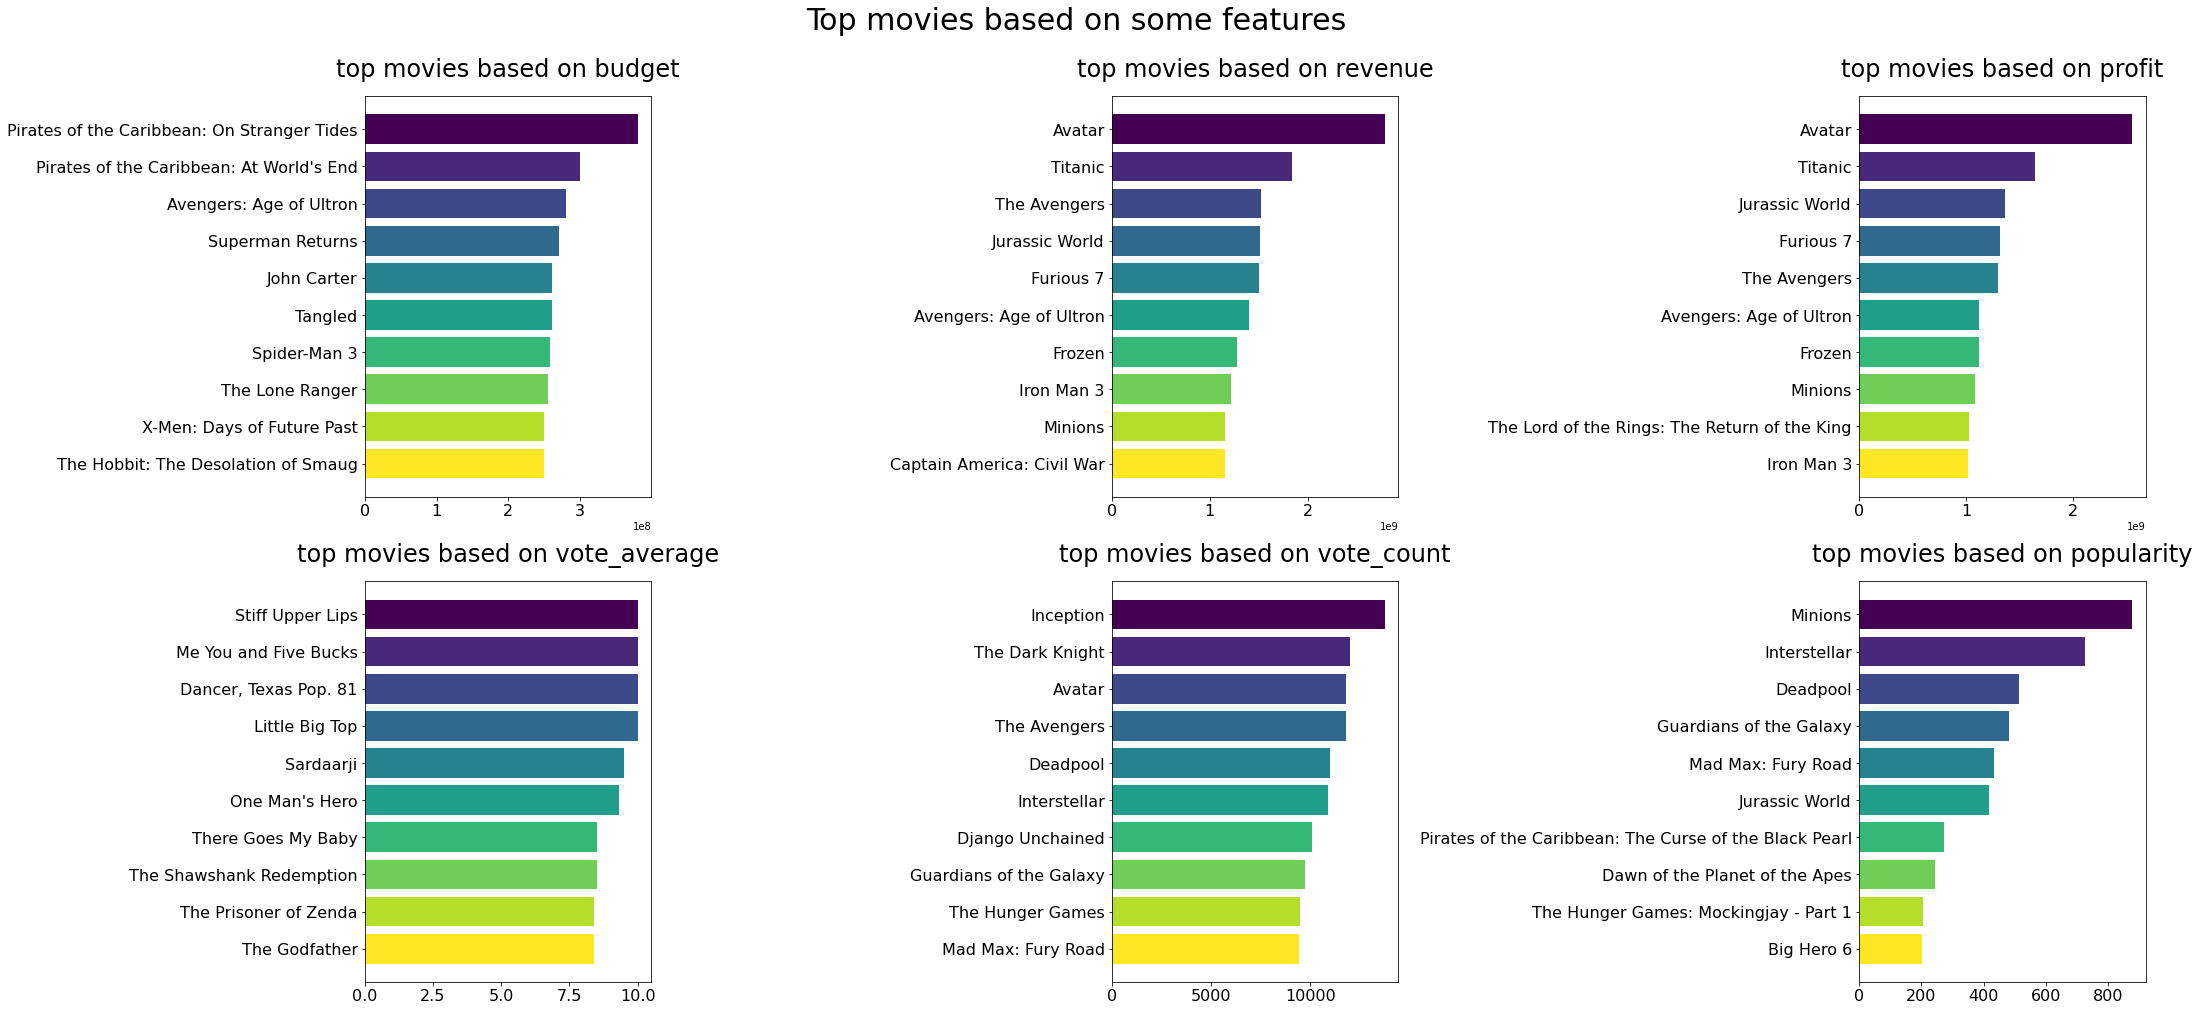

In [17]:
top_movie_num = 10
top_movies_based_on = ["budget", "revenue", "profit", "vote_average", "vote_count", "popularity"]

fig, ax = plt.subplots(len(top_movies_based_on)//3, 3, figsize=(30,14))
colors = plt.cm.get_cmap('viridis', top_movie_num)

for i, col in enumerate(top_movies_based_on):
    top_movies_by = movie_df.sort_values(by=[col], ascending=False).head(top_movie_num)
    r, c = i//3, i%3
    ax[r][c].barh(top_movies_by["title"], top_movies_by[col], color=colors.colors)
    ax[r][c].set_title(f"top movies based on {col}", fontsize=24, pad=20)
    ax[r][c].tick_params(axis='both', which='major', labelsize=16)
    ax[r][c].invert_yaxis()    
    
plt.suptitle('Top movies based on some features',fontsize=30, y=1)
fig.tight_layout()

- genres

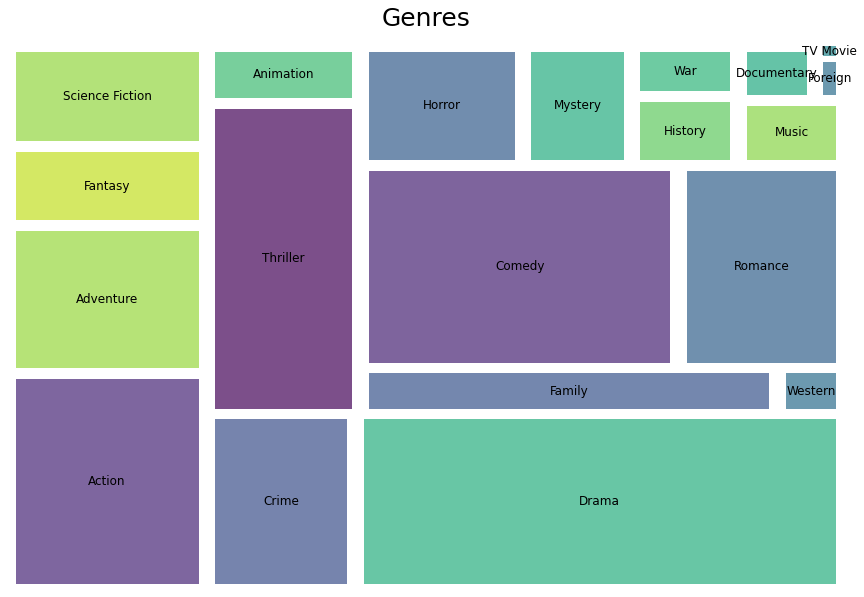

In [18]:
# plot genre frequncy with treemap 
genres_flatten = sum(movie_df["genres"].values, []) # genres are list of lists
genres_info = Counter(genres_flatten)

plt.figure(figsize=(15, 10))
plt.title("Genres", fontsize=25, pad=20)
squarify.plot(genres_info.values(), label=genres_info.keys(), text_kwargs={'fontsize':12}, bar_kwargs={'alpha':.7}, pad=True)
plt.axis("off");

- keywords

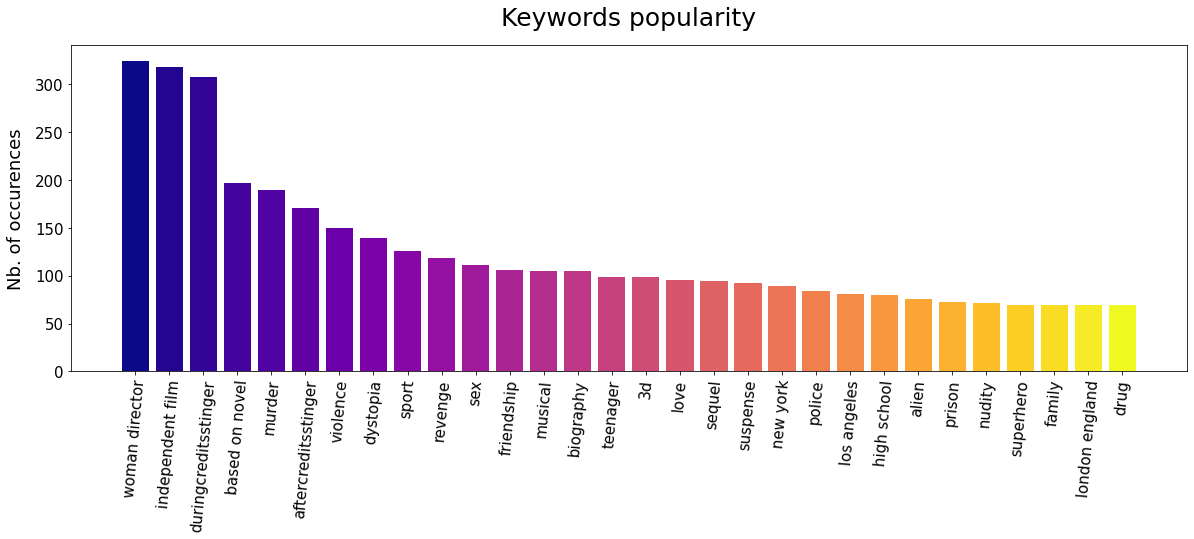

In [19]:
top_keywords_num = 30
keywords_flatten = sum(movie_df["keywords"].values, []) # keywords are list of lists
keywords_info = Counter(keywords_flatten)
top_keywords = dict(keywords_info.most_common(top_keywords_num))

plt.figure(figsize=(20, 6))
plt.xticks(rotation=85, fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel("Nb. of occurences", fontsize=18, labelpad=10)
plt.bar(top_keywords.keys(), top_keywords.values(), align='center', color=plt.cm.get_cmap('plasma', top_keywords_num).colors)
plt.title("Keywords popularity", fontsize=25, pad=20)
plt.show()

- original_language

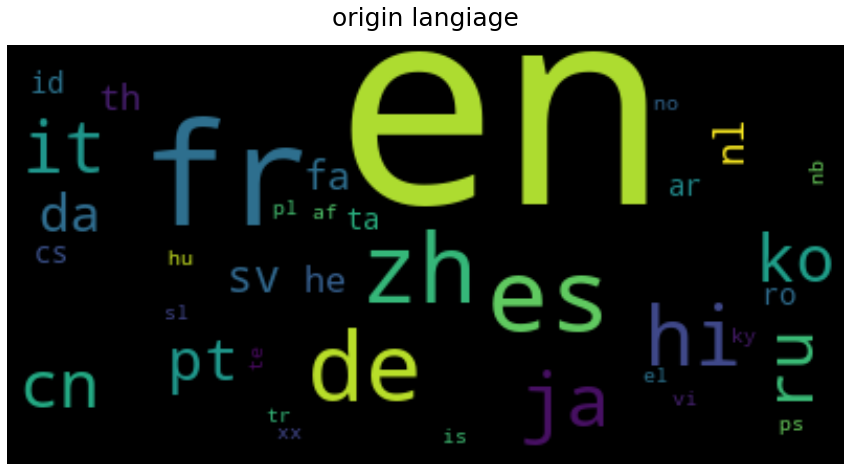

In [20]:
# plot unique cast frequency
language_info = movie_df["original_language"].value_counts()[:50]

wordcloud = WordCloud(background_color='black')
wordcloud.generate_from_frequencies(dict(language_info))

plt.figure(figsize=(15,10))
plt.title("origin langiage", fontsize=25, pad=20)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off");

- production_countries

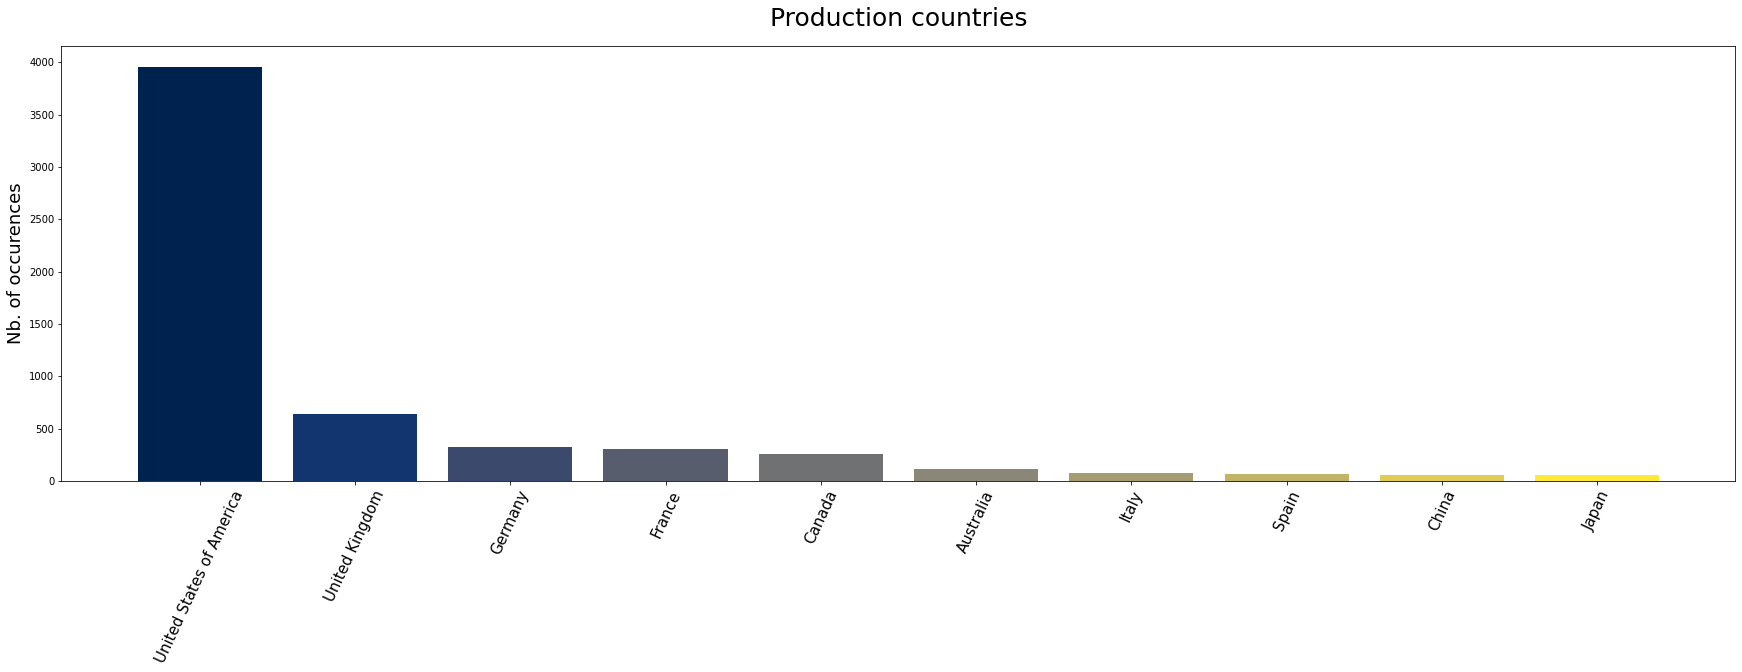

In [21]:
top_contries_num = 10
production_contries_flatten = sum(movie_df["production_countries"].values, []) # production_countries are list of lists
production_contries_info = Counter(production_contries_flatten)
top_production_contries = production_contries_info.most_common(top_contries_num)

plt.figure(figsize=(30, 8))
plt.xticks(rotation=65, fontsize=15)
plt.ylabel("Nb. of occurences", fontsize=18)
plt.title("Production countries", fontsize=25, pad=20)
plt.bar(dict(top_production_contries).keys(), dict(top_production_contries).values(), color=plt.cm.get_cmap('cividis', top_contries_num).colors);

- production_companies

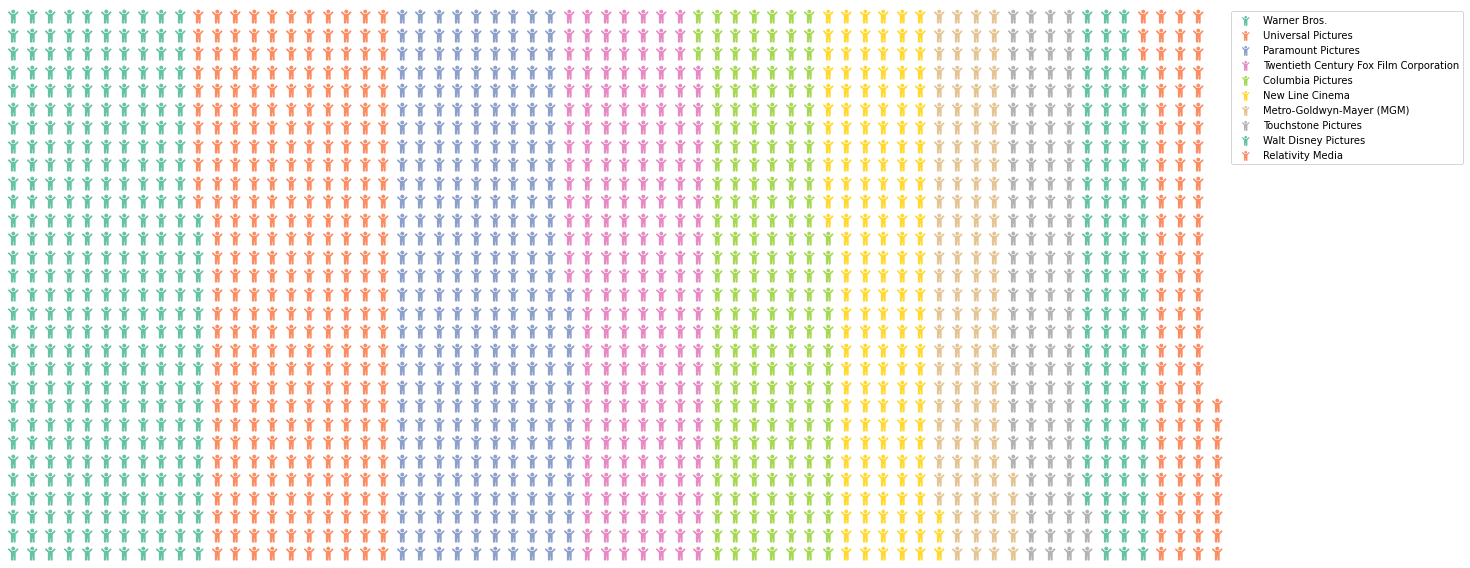

In [22]:
production_companies_flatten = sum(movie_df["production_companies"].values, []) # production_companies are list of lists
production_companies_info = Counter(production_companies_flatten)
top_production_companies = production_companies_info.most_common(10)

fig = plt.figure(
    FigureClass=Waffle, 
    rows=30, 
    values=dict(top_production_companies), 
    legend={'loc': 'upper left', 'bbox_to_anchor': (1, 1)},
    icons='child', icon_size=14, 
    icon_legend=True,
    figsize=(24,8)
)

- cast

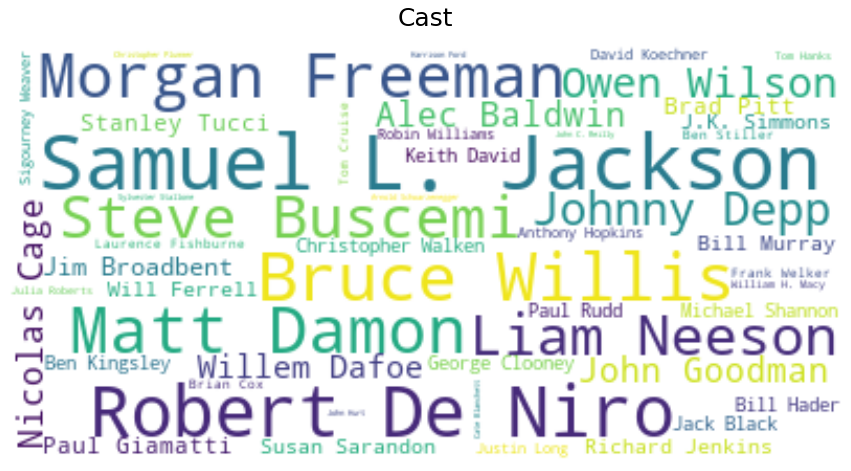

In [23]:
# plot unique cast frequency
cast_flatten = sum(movie_df["cast"].values, []) # cast are list of lists
cast_info = Counter(cast_flatten)

wordcloud = WordCloud(background_color='white')
wordcloud.generate_from_frequencies(dict(cast_info.most_common(50)))

plt.figure(figsize=(15,10))
plt.title("Cast", fontsize=25, pad=20)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off");

- release_year, release_month

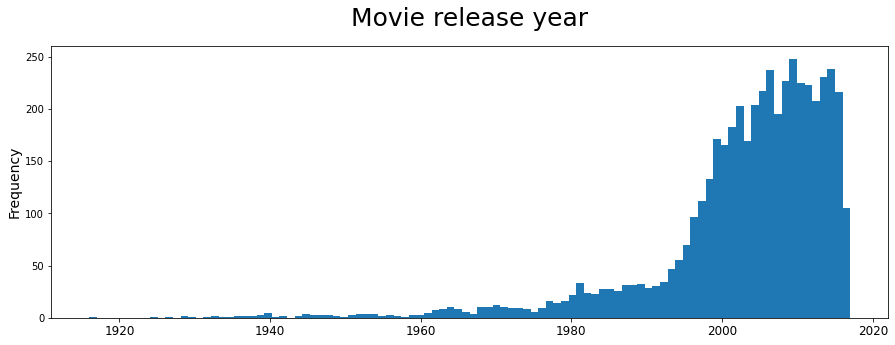

In [24]:
plt.xticks(fontsize=12)
plt.ylabel("Nb. of occurences", fontsize=14)
plt.title("Movie release year", fontsize=25, pad=20)
movie_df["release_year"].plot.hist(figsize=(15,5), bins=100);

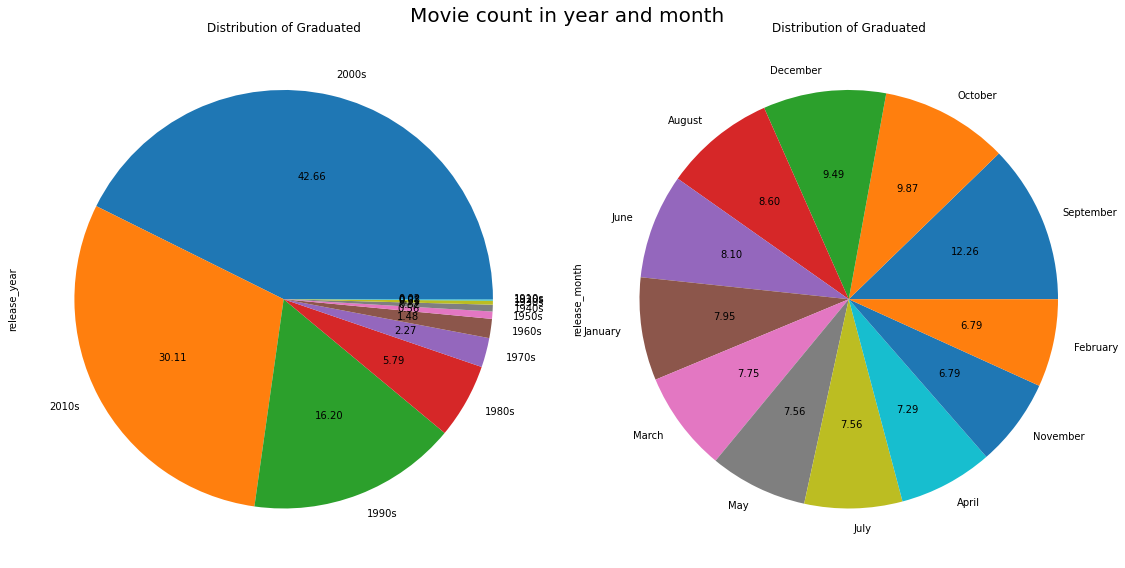

In [25]:
fig, ax  = plt.subplots(1,2,figsize = (16,8))
fig.suptitle('Movie count in year and month', fontsize=20)

movie_count_in_10th_year = movie_df["release_year"].dropna().apply(lambda x:str(int(x)//10*10)+'s').value_counts()
movie_count_in_month = movie_df["release_month"].value_counts()
    
movie_count_in_10th_year.plot.pie(title='Distribution of Graduated', ax=ax[0], autopct="%.2f")
movie_count_in_month.plot.pie(title='Distribution of Graduated', ax=ax[1], autopct="%.2f")
fig.tight_layout()

## 1. What areas have the most influence on revenue?

- Correlation

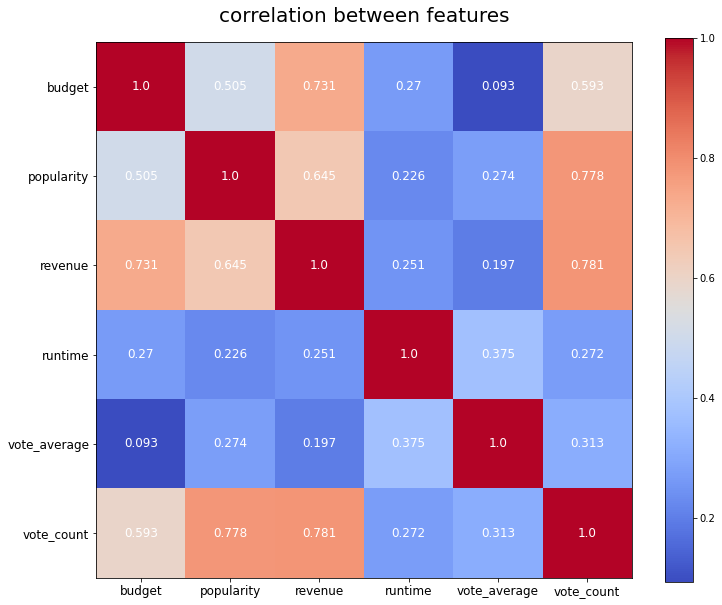

In [26]:
matrix = movie_df[["budget", "popularity", "revenue", "runtime", "vote_average", "vote_count"]].corr()

f, ax = plt.subplots(figsize=(12, 10))
plt.title("correlation between features", fontsize=20, pad=20)
plt.xticks(range(len(matrix.index)), matrix.index, fontsize=12)
plt.yticks(range(len(matrix.index)), matrix.index, fontsize=12)

# adding values
for i in range(len(matrix.index)):
    for j in range(len(matrix.index)):
        text = ax.text(j, i, round(matrix.iloc[i, j],3), ha="center", va="center", color="w", fontsize=12)
        
plt.imshow(matrix, cmap='coolwarm', interpolation='nearest')
plt.colorbar();

- According the correlation matrix, the vote_count feature have the most influence to the revenue

## 2. How is a movie's revenue and average score affected by its genre?

### Get movie's revenue and average score by genre

- Revenue

In [27]:
def get_genres_revenue(genres_name):
    genres_list_idx = [idx for (idx, val) in movie_df.genres.items() if genres_name in val]
    genres_revenue = [val for (idx, val) in movie_df.revenue.items() if idx in genres_list_idx]
    return genres_revenue

In [28]:
genres_info.most_common(10)

[('Drama', 2297),
 ('Comedy', 1722),
 ('Thriller', 1274),
 ('Action', 1154),
 ('Romance', 894),
 ('Adventure', 790),
 ('Crime', 696),
 ('Science Fiction', 535),
 ('Horror', 519),
 ('Family', 513)]

In [29]:
Drama_revenue =  get_genres_revenue('Drama')
Comedy_revenue =  get_genres_revenue('Comedy')
Thriller_revenue =  get_genres_revenue('Thriller')
Action_revenue =  get_genres_revenue('Action')

In [30]:
Other_revenue_list = list(genres_info.keys())

In [31]:
for i in ['Drama', 'Comedy', 'Thriller', 'Action']:
    Other_revenue_list.remove(i)

In [32]:
Other_revenue = []
for i in Other_revenue_list:
    Other = get_genres_revenue(i)
    Other_revenue = list(set(Other + Other_revenue))

- Average score

In [33]:
def get_genres_vote_average(genres_name):
    genres_list_idx = [idx for (idx, val) in movie_df.genres.items() if genres_name in val]
    genres_vote_average = [val for (idx, val) in movie_df.vote_average.items() if idx in genres_list_idx]
    return genres_vote_average

In [34]:
Drama_vote_average =  get_genres_vote_average('Drama')
Comedy_vote_average =  get_genres_vote_average('Comedy')
Thriller_vote_average =  get_genres_vote_average('Thriller')
Action_vote_average =  get_genres_vote_average('Action')

In [35]:
Other_vote_average_list = list(genres_info.keys())

In [36]:
for i in ['Drama', 'Comedy', 'Thriller', 'Action']:
    Other_vote_average_list.remove(i)

In [37]:
Other_vote_average = []
for i in Other_vote_average_list:
    Other = get_genres_vote_average(i)
    Other_vote_average = list(set(Other + Other_vote_average))

### Hypothesis testing

Step 1: Define null and alternative hypothesis

- H0: μ1=μ2=μ3=μ4=μ5  The genre of movies have not effect on the revenue and average score
 
- H1: The genre of movies have effect on the revenue and average score

Step 2: Decide the significance level

- α = 0.05

Step 3: Identify Test

- One-way ANOVA - Equality of population through variances of samples. 

Step 4: Calculate the test-statistics and p-value

In [38]:
from scipy.stats import f_oneway
f_oneway(Drama_revenue, Comedy_revenue, Thriller_revenue, Action_revenue, Other_revenue)

F_onewayResult(statistic=104.4639400084456, pvalue=3.9616988647610788e-87)

In [39]:
from scipy.stats import f_oneway
f_oneway(Drama_vote_average, Comedy_vote_average, Thriller_vote_average, Action_vote_average, Other_vote_average)

F_onewayResult(statistic=66.25538978544624, pvalue=5.013816349541375e-55)

Step 5: Decide to reject or accept null hypothesis

p-value is 3.9616988647610788e-87 and 5.013816349541375e-55, it is less than aplha(0.05). 

We reject the null hypothesis and conclude that the genre of movies have effect on the revenue and average score 

## 3. What influence does release date have on revenue? 

[Text(0.5, 1.0, 'Month Vs Revenue')]

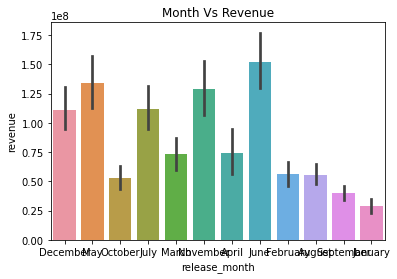

In [40]:
sns.barplot(x=movie_df.release_month, y = movie_df.revenue).set(title='Month Vs Revenue')

[Text(0.5, 1.0, 'Day of week Vs Revenue')]

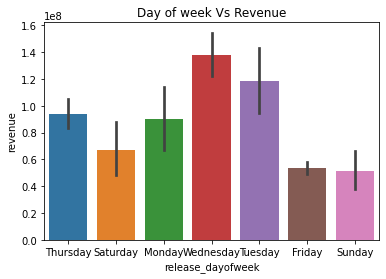

In [41]:
sns.barplot(x=movie_df.release_dayofweek, y = movie_df.revenue).set(title='Day of week Vs Revenue')

In [42]:
movie_df.head(1)

,budget,genres,id,keywords,original_language,original_title,popularity,production_companies,production_countries,revenue,runtime,spoken_languages,status,title,vote_average,vote_count,cast,crew,release_year,release_month,release_dayofweek,profit
0,237000000,"[Action, Adventure, Fantasy, Science Fiction]",19995,"[culture clash, future, space war, space colon...",en,Avatar,150.437577,"[Ingenious Film Partners, Twentieth Century Fo...","[United States of America, United Kingdom]",2787965087,162.0,"[English, Español]",Released,Avatar,7.2,11800,"[Sam Worthington, Zoe Saldana, Sigourney Weave...","[{'credit_id': '52fe48009251416c750aca23', 'de...",2009.0,December,Thursday,2550965087


In [43]:
movie_df.release_dayofweek.replace(['Thursday', 'Saturday', 'Monday', 'Wednesday', 'Tuesday', 'Friday',
       'Sunday'], [3, 5, 0, 2, 1, 4, 6], inplace = True)

In [44]:
movie_df.release_month.replace(['December', 'May', 'October', 'July', 'March', 'November', 'April',
       'June', 'February', 'August', 'September', 'January'], [12, 5, 10, 7, 3, 11, 4, 6, 2, 8, 9, 1], inplace = True)

In [45]:
movie_df.head(1)

,budget,genres,id,keywords,original_language,original_title,popularity,production_companies,production_countries,revenue,runtime,spoken_languages,status,title,vote_average,vote_count,cast,crew,release_year,release_month,release_dayofweek,profit
0,237000000,"[Action, Adventure, Fantasy, Science Fiction]",19995,"[culture clash, future, space war, space colon...",en,Avatar,150.437577,"[Ingenious Film Partners, Twentieth Century Fo...","[United States of America, United Kingdom]",2787965087,162.0,"[English, Español]",Released,Avatar,7.2,11800,"[Sam Worthington, Zoe Saldana, Sigourney Weave...","[{'credit_id': '52fe48009251416c750aca23', 'de...",2009.0,12,3,2550965087


In [46]:
#creating groups of bmi
category=pd.cut(movie_df.release_year,bins=[1916.0,1960.0,1975.0,1990.0,2017.0],labels=['1916-1960', '1960-1975', '1975-1990', '1990-2017'])
movie_df.insert(6,'RevenueByYear',category)

In [47]:
movie_df.head(2)

,budget,genres,id,keywords,original_language,original_title,RevenueByYear,popularity,production_companies,production_countries,revenue,runtime,spoken_languages,status,title,vote_average,vote_count,cast,crew,release_year,release_month,release_dayofweek,profit
0,237000000,"[Action, Adventure, Fantasy, Science Fiction]",19995,"[culture clash, future, space war, space colon...",en,Avatar,1990-2017,150.437577,"[Ingenious Film Partners, Twentieth Century Fo...","[United States of America, United Kingdom]",2787965087,162.0,"[English, Español]",Released,Avatar,7.2,11800,"[Sam Worthington, Zoe Saldana, Sigourney Weave...","[{'credit_id': '52fe48009251416c750aca23', 'de...",2009.0,12,3,2550965087
1,300000000,"[Adventure, Fantasy, Action]",285,"[ocean, drug abuse, exotic island, east india ...",en,Pirates of the Caribbean: At World's End,1990-2017,139.082615,"[Walt Disney Pictures, Jerry Bruckheimer Films...",[United States of America],961000000,169.0,[English],Released,Pirates of the Caribbean: At World's End,6.9,4500,"[Johnny Depp, Orlando Bloom, Keira Knightley, ...","[{'credit_id': '52fe4232c3a36847f800b579', 'de...",2007.0,5,5,661000000


In [48]:
movie_df.groupby(movie_df.RevenueByYear).revenue.mean()

RevenueByYear
1916-1960    2.354609e+07
1960-1975    4.096004e+07
1975-1990    6.777597e+07
1990-2017    8.572456e+07
Name: revenue, dtype: float64

[Text(0.5, 1.0, 'Release Year Vs Revenue')]

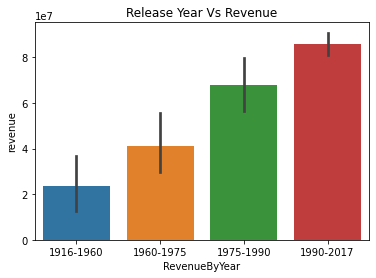

In [49]:
sns.barplot(x=movie_df.RevenueByYear,y=movie_df.revenue).set(title='Release Year Vs Revenue')

- Revenue is increasing year by year

In [50]:
#creating groups of bmi
category=pd.cut(movie_df.release_month,bins=[1,3,6,9,12],labels=['Spring', 'Summer', 'Autumn', 'Winter'])
movie_df.insert(6,'RevenueBySeason',category)

In [51]:
movie_df.groupby(movie_df.RevenueBySeason).revenue.mean()

RevenueBySeason
Spring    6.517980e+07
Summer    1.213521e+08
Autumn    6.378389e+07
Winter    9.384485e+07
Name: revenue, dtype: float64

[Text(0.5, 1.0, 'Release Season Vs Revenue')]

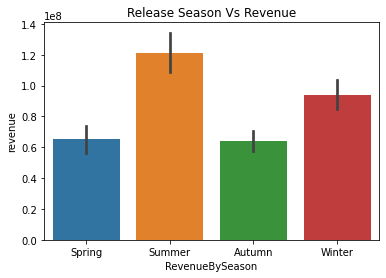

In [52]:
sns.barplot(x=movie_df.RevenueBySeason,y=movie_df.revenue).set(title='Release Season Vs Revenue')

- Summer is month of year have the most viewers